# **Semiconductor_Band Gap Prediction (Regression)**

# **1. Data Loading**




In [107]:
import kagglehub
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# --- 1. Download & Load Data ---
# Download dataset
path = kagglehub.dataset_download("allanwandia/material-science")

# Find the CSV file in the download folder
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
full_path = os.path.join(path, csv_files[0])

df = pd.read_csv(full_path)

Using Colab cache for faster access to the 'material-science' dataset.


# **2. Checking data information**




**Basic command for checking data information**



```
df.info()
df.head()
df.tail()
df.describe()
df.columns

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86988 entries, 0 to 86987
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   material_id                86988 non-null  object 
 1   formula_pretty             86988 non-null  object 
 2   n_elements                 86988 non-null  int64  
 3   contains_transition_metal  86988 non-null  bool   
 4   formation_energy_per_atom  86988 non-null  float64
 5   energy_per_atom            86988 non-null  float64
 6   band_gap                   86988 non-null  float64
 7   is_semiconductor           86988 non-null  bool   
 8   density                    86988 non-null  float64
 9   volume                     86988 non-null  float64
 10  elements                   86988 non-null  object 
dtypes: bool(2), float64(5), int64(1), object(3)
memory usage: 6.1+ MB


**Check for missing values**

In [109]:
# Check for missing values
print('Missing values in each column:')
print(df.isnull().sum())



Missing values in each column:
material_id                  0
formula_pretty               0
n_elements                   0
contains_transition_metal    0
formation_energy_per_atom    0
energy_per_atom              0
band_gap                     0
is_semiconductor             0
density                      0
volume                       0
elements                     0
dtype: int64


**If any numeric columns have missing values, fill them with the median**

In [110]:
# Basic cleaning: if any numeric columns have missing values, fill them with the median

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# For any categorical columns with missing values, fill with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna('Unknown', inplace=True)

# Final shape after cleaning
print('Data shape after cleaning:', df.shape)

Data shape after cleaning: (86988, 11)


In [111]:
df.tail()

,material_id,formula_pretty,n_elements,contains_transition_metal,formation_energy_per_atom,energy_per_atom,band_gap,is_semiconductor,density,volume,elements
86983,mp-1001069,Li48P16S61,3,False,0.890142,0.773741,0.686062,True,-1.344163,6.430479,"['Li', 'P', 'S']"
86984,mp-676829,Li49Cu8N19,3,False,1.686606,0.543630,-0.868213,False,-1.028787,1.177355,"['Cu', 'Li', 'N']"
86985,mp-722623,Li66Be24H35,3,False,2.117250,1.320546,-0.868213,False,-1.966237,2.955622,"['Be', 'H', 'Li']"
86986,mp-647275,Ba39Li80N9,3,False,2.097097,1.405895,-0.868213,False,-0.814328,10.189519,"['Ba', 'Li', 'N']"
86987,mp-1185524,Li95Mn16O64,3,True,-0.079223,0.449108,-0.868213,False,-0.839734,3.685992,"['Li', 'Mn', 'O']"


In [112]:
df.describe()

,n_elements,formation_energy_per_atom,energy_per_atom,band_gap,density,volume
count,86988.000000,8.698800e+04,8.698800e+04,8.698800e+04,8.698800e+04,8.698800e+04
mean,3.886099,8.628976e-15,8.820440e-15,7.784048e-15,-1.248506e-14,-1.394490e-14
std,0.746630,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,2.000000,-2.333873e+00,-1.662359e+01,-8.682129e-01,-2.477204e+00,-1.194165e+00
25%,3.000000,-6.245452e-01,-1.117969e-01,-8.682129e-01,-5.720758e-01,-6.209157e-01
50%,4.000000,-2.581734e-01,6.315191e-02,-3.681771e-01,-1.676467e-01,-3.418060e-01
75%,4.000000,2.759976e-01,2.902369e-01,6.349414e-01,3.265572e-01,3.349606e-01
max,8.000000,7.952180e+00,2.055498e+00,5.033428e+00,1.032946e+01,1.992366e+01


**Histogram for numeric columns**

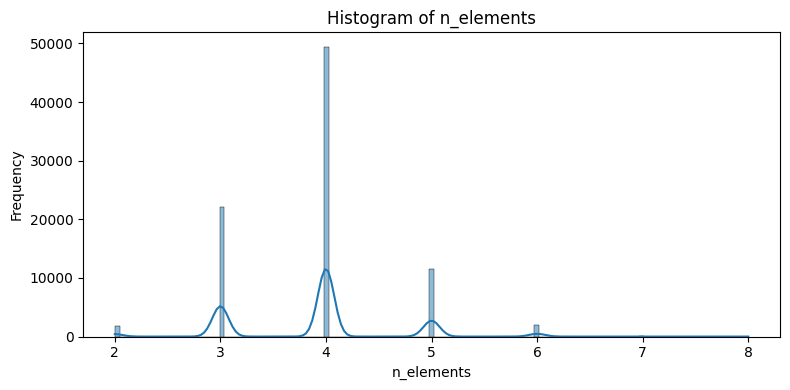

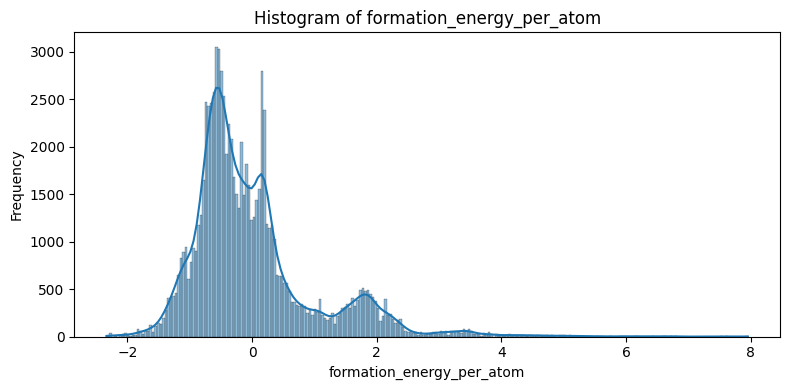

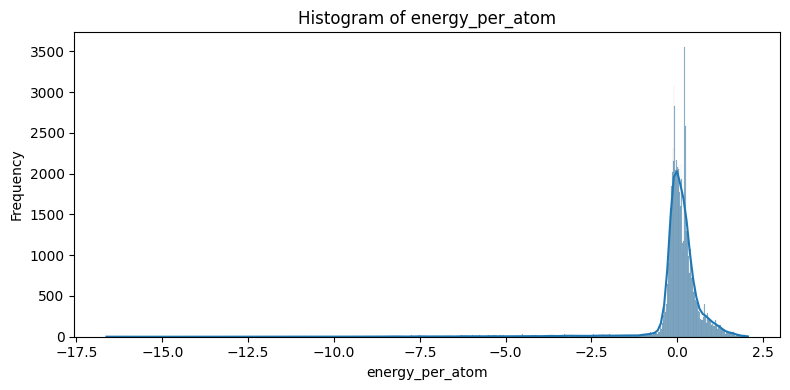

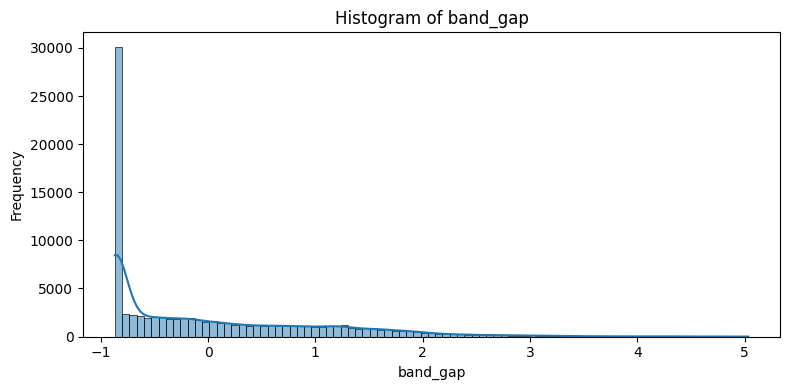

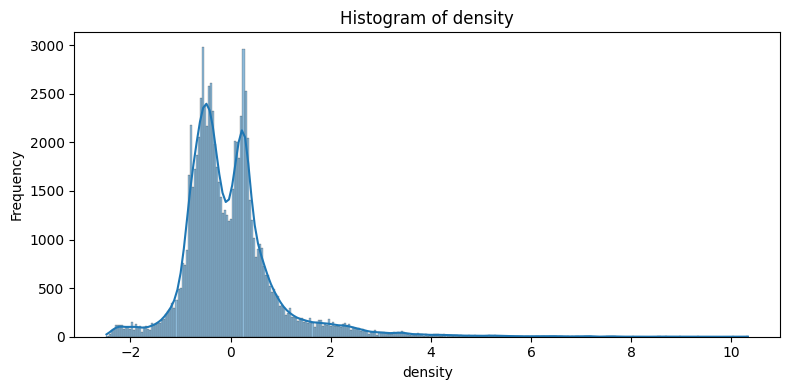

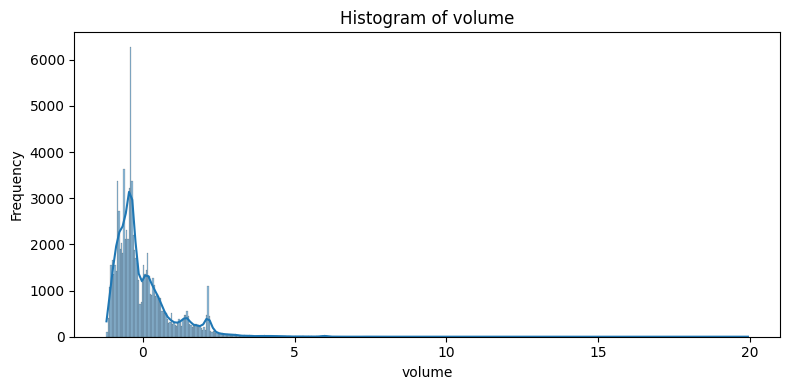

In [113]:
## Histogram for numeric columns
numeric_df = df.select_dtypes(include=[np.number])
for col in numeric_df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

**Correlation Heatmap**

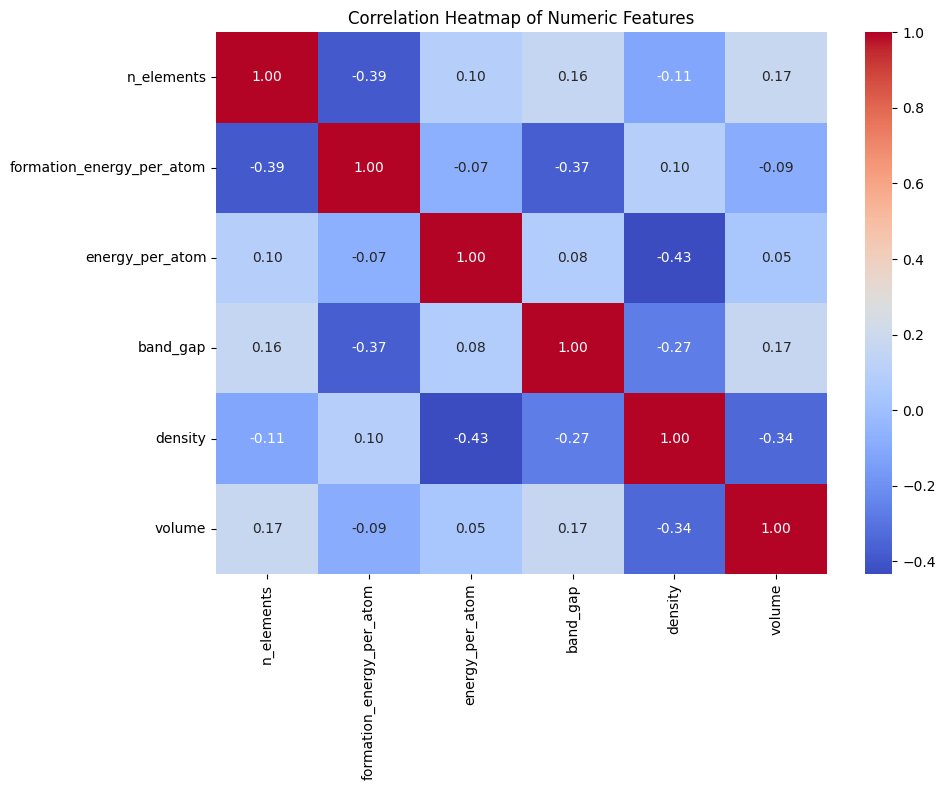

In [115]:
## Correlation Heatmap (if there are 4 or more numeric columns)
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()


**Pair Plot for variables**

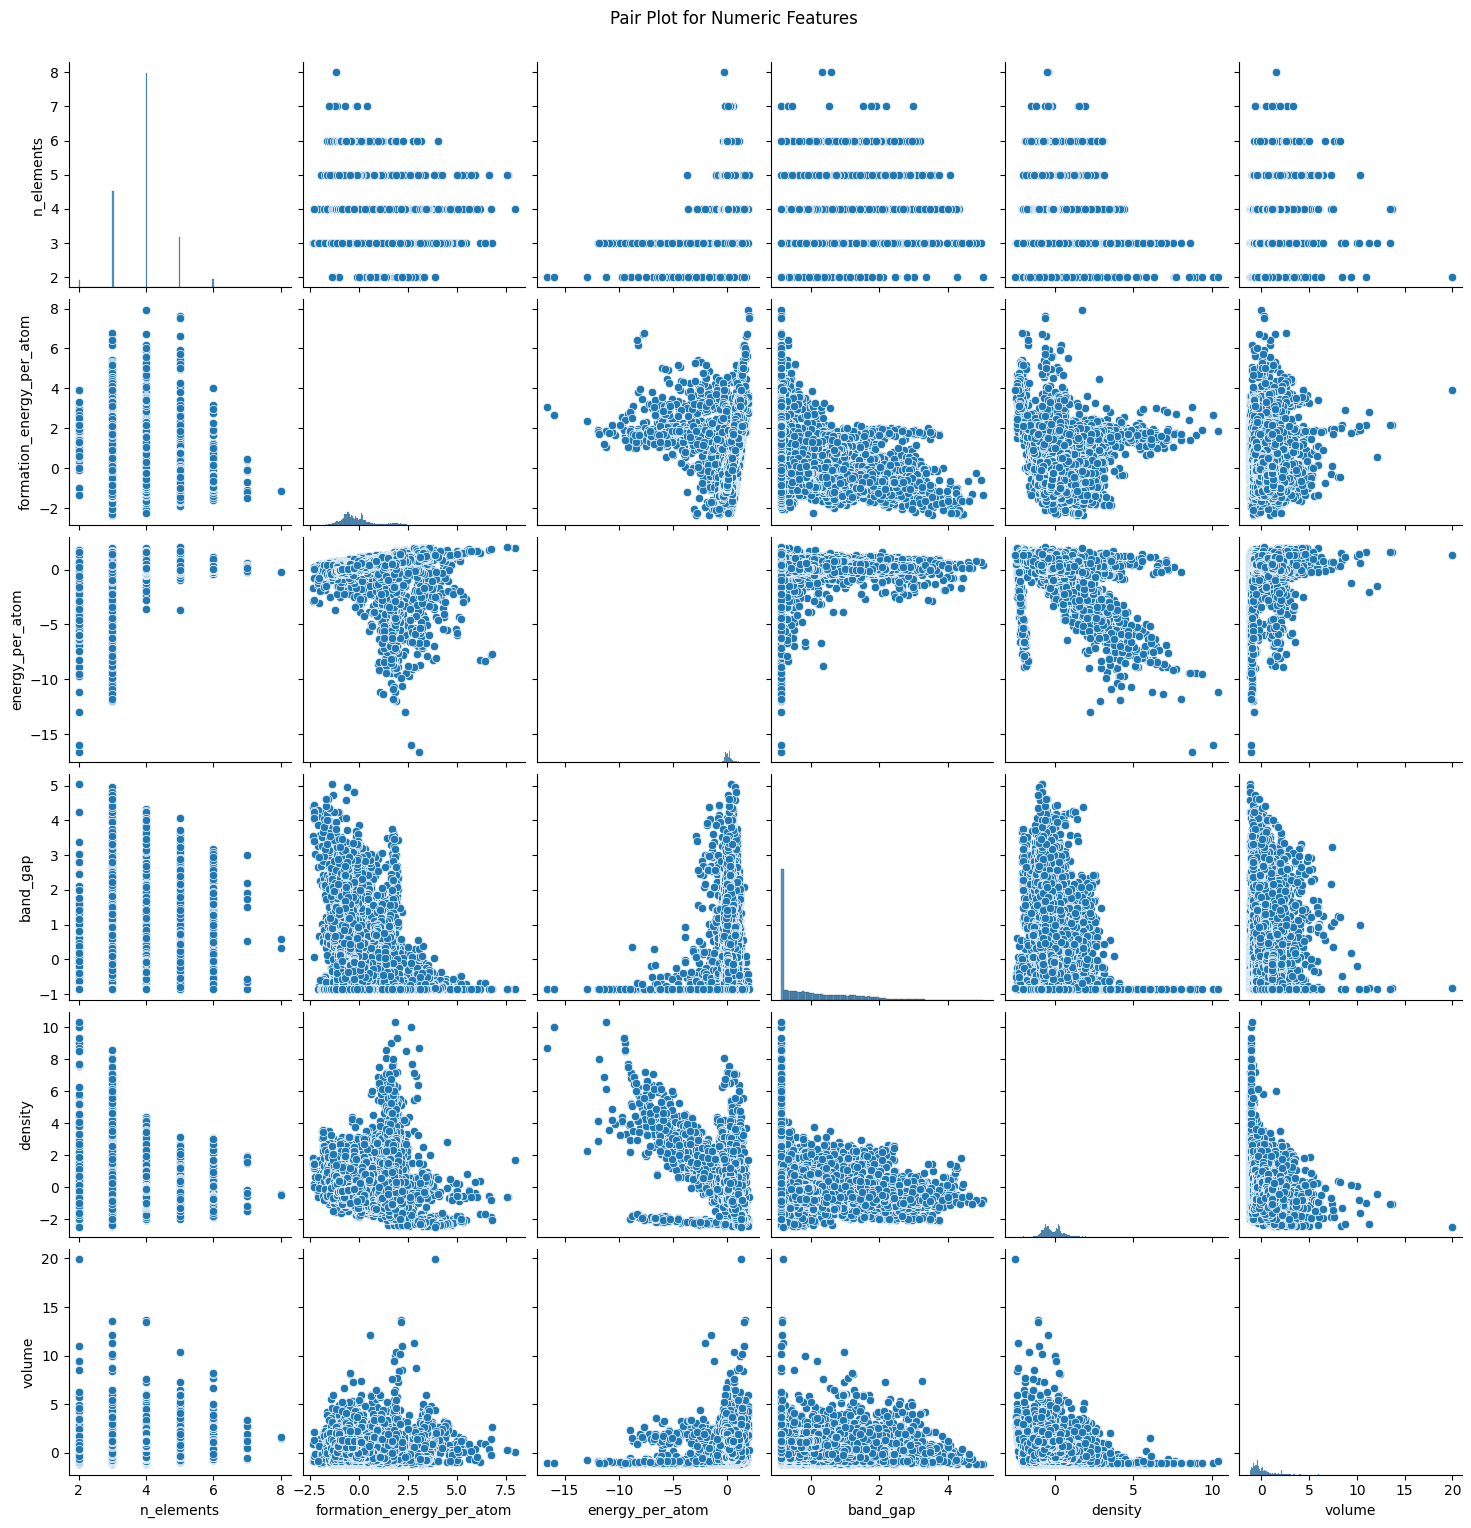

In [116]:
sns.pairplot(numeric_df)
plt.suptitle('Pair Plot for Numeric Features', y=1.02)
plt.show()

# **3. Modeling**

**Define target variable and select feature set**


In [117]:
# Target: Convert True/False to 1/0
df_class = df.copy()
df_class['target'] = df_class['band_gap']
df_class['target'].head()

,target
0,-0.765226
1,-0.808019
2,0.626478
3,0.620655
4,-0.868213


**Features: Physical properties**

In [118]:
# Features: Physical properties
features = ['density', 'formation_energy_per_atom', 'volume', 'n_elements']
X = df_class[features]
y = df_class['target']

**Split Data**

In [119]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Train Single Model**

In [120]:
# Evaluate ---
import numpy as np
import joblib
best_model =  RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train)

# Display training and testing scores
print('Training Score:', best_model.score(X_train, y_train))
print('Testing Score:', best_model.score(X_test, y_test))

# Evaluate RMSE for the best model
best_model_pred = best_model.predict(X_test)
best_model_mae = np.sqrt(mean_absolute_error(y_test, best_model_pred))
print(f'Best Model MAE: {best_model_mae:.4f}')



Training Score: 0.9973932670709346
Testing Score: 0.9824757905792179
Best Model MAE: 0.2443


**Multiple Modeling**

In [121]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Setup the 6 Contenders
models = {
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbors": make_pipeline(StandardScaler(), KNeighborsRegressor()),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting (sklearn)": GradientBoostingRegressor(random_state=42),
    "Neural Network": make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)),
    "XGBoost": XGBRegressor(random_state=42)
}

# List to store results for sorting
results_list = []

print("Training models... please wait.")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store in list
    results_list.append({
        "Model": name,
        "R2": r2,
        "MAE": mae
    })

# --- SORTING LOGIC ---
# Sort by R2 Score in Descending order (Highest R2 is best)
# If you prefer MAE, change key to x['MAE'] and reverse=False
sorted_results = sorted(results_list, key=lambda x: x['R2'], reverse=True)

# --- PRINTING ---
print("\n" + "="*55)
print(f"{'Model Name':<30} | {'R2 Score':<10} | {'MAE (eV)':<10}")
print("-" * 55)

for res in sorted_results:
    print(f"{res['Model']:<30} | {res['R2']:.4f}     | {res['MAE']:.4f}")
print("="*55)
print(f"🏆 Best Model: {sorted_results[0]['Model']}")

Training models... please wait.

Model Name                     | R2 Score   | MAE (eV)  
-------------------------------------------------------
Random Forest                  | 0.9825     | 0.0597
K-Nearest Neighbors            | 0.7719     | 0.2676
XGBoost                        | 0.6442     | 0.4264
Neural Network                 | 0.4818     | 0.5154
Gradient Boosting (sklearn)    | 0.4000     | 0.5766
Linear Regression              | 0.1962     | 0.7087
🏆 Best Model: Random Forest


# **7. Save the best model**

In [122]:
import joblib

# 1. Identify the Winner
# Grab the name of the model in the first row (since it's sorted by R2 descending)
best_model_name = sorted_results[0]['Model']
print(f"\n🏆 The Best Model is: {best_model_name}")

# 2. Retrieve the Trained Object
# Look up the actual model object from your original 'models' dictionary
best_model = models[best_model_name]

# 3. Save to Disk
filename = 'best_concrete_model_BG.pkl'
joblib.dump(best_model, filename)

print(f"✅ Successfully saved {best_model_name} to '{filename}'")


🏆 The Best Model is: Random Forest
✅ Successfully saved Random Forest to 'best_concrete_model_BG.pkl'


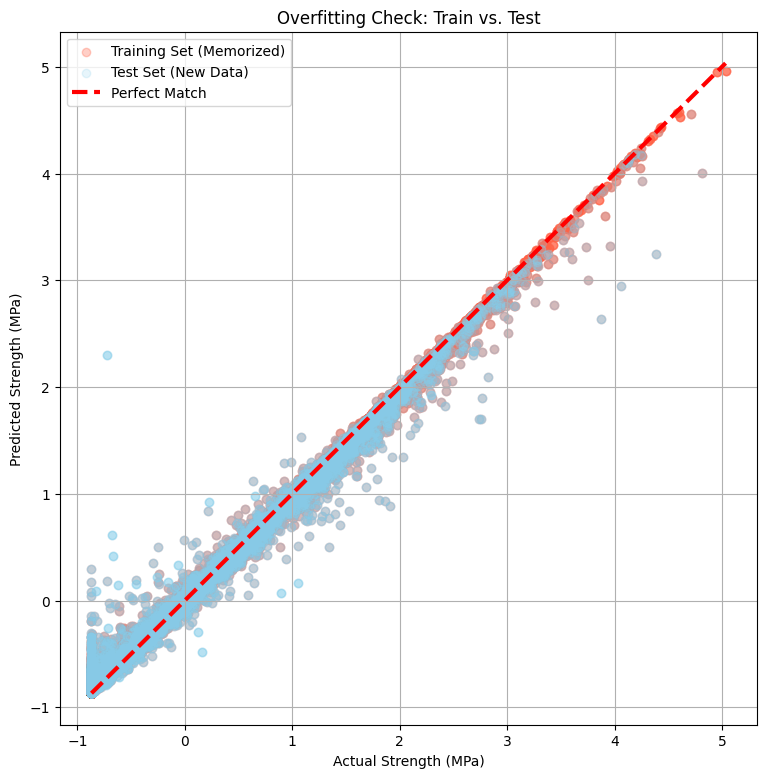

In [123]:
import matplotlib.pyplot as plt

# 1. Get predictions for BOTH sets
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

plt.figure(figsize=(9, 9))

# 2. Plot Training Data
# We use a lower 'alpha' (transparency) because there are usually many more training points
plt.scatter(y_train, train_preds, color='tomato', alpha=0.3, label='Training Set (Memorized)')

# 3. Plot Test Data
plt.scatter(y_test, test_preds, color='skyblue', alpha=0.2, label='Test Set (New Data)')

# 4. Draw the "Perfect Prediction" Line
min_val = min(y.min(), train_preds.min()) # Find the lowest value in the whole dataset
max_val = max(y.max(), train_preds.max()) # Find the highest value
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Perfect Match')

plt.title("Overfitting Check: Train vs. Test")
plt.xlabel("Actual Strength (MPa)")
plt.ylabel("Predicted Strength (MPa)")
plt.legend()
plt.grid(True)
plt.show()

# **6. Feature importances**


--- Feature Importance for Random Forest Regressor ---
                     Feature  Importance
1  formation_energy_per_atom    0.431208
0                    density    0.291261
2                     volume    0.232104
3                 n_elements    0.045426


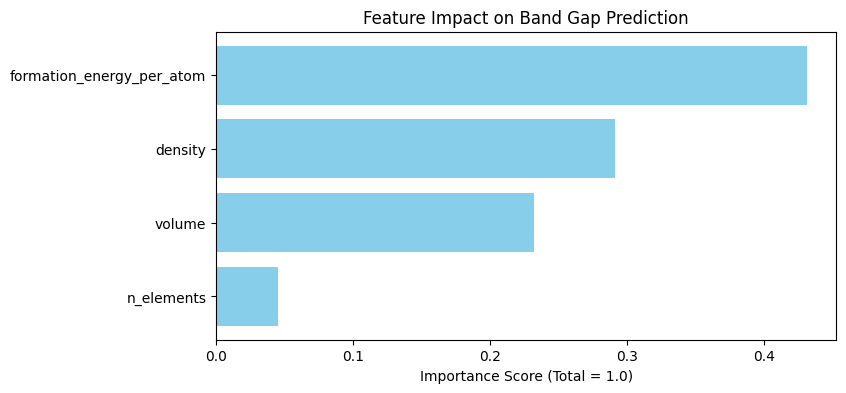

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'best_model' now holds the trained RandomForestRegressor
# If not, you can load it: best_model = joblib.load('best_materials_model.pkl')
# For this example, let's assume you access the trained object from the loop.

# --- 1. Get the Importance Scores ---
# This is a key feature of all tree-based models!
importances = best_model.feature_importances_

# 2. Create a clean table
# Features list needs to be defined: features = ['density', 'formation_energy_per_atom', 'volume', 'n_elements']
features = ['density', 'formation_energy_per_atom', 'volume', 'n_elements'] # Assuming your list

feature_table = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# 3. Sort and print
feature_table = feature_table.sort_values(by='Importance', ascending=False)
print("\n--- Feature Importance for Random Forest Regressor ---")
print(feature_table)

# 4. Visualize it!
plt.figure(figsize=(8, 4))
plt.barh(feature_table['Feature'], feature_table['Importance'], color='skyblue')
plt.xlabel('Importance Score (Total = 1.0)')
plt.title('Feature Impact on Band Gap Prediction')
plt.gca().invert_yaxis()
plt.show()

In [131]:
import pandas as pd

# 1. Check the feature names expected by the model
# (Run this line to see the correct names/order)
#print(f"Feature names expected: {loaded_model.feature_names_in_}")

# 2. Create a DataFrame with the correct column names
# ** IMPORTANT: The names and order must match Step 1 exactly **
new_material_df = pd.DataFrame([[5.0, -1.2, 100, 3]],
                               columns=loaded_model.feature_names_in_)

# 3. Make prediction (The warning will be gone)
prediction = loaded_model.predict(new_material_df)
print(f"Predicted band gap: {prediction[0]:.4f}")


Predicted band gap: -0.2376
